# MetaVoxel Tutorial

In [1]:
# Amira Abdel-Rahman
# (c) Massachusetts Institute of Technology 2020

# tested using julia 1.5.2 and windows Nvidia geforce gtx 1070 Ti

### Import Julia Libraries

In [1]:
using LinearAlgebra
import JSON
using StaticArrays, BenchmarkTools
using Base.Threads
using CUDA
import Base: +, * , -, ^

In [2]:
include("./julia/include/vector.jl") #utils for vectors and quaternions
include("./julia/include/material.jl") #utils for node and edge material
include("./julia/include/export.jl") #export simulation data to json
include("./julia/include/run.jl") #turn setup to cuda arrays and run simulation
include("./julia/include/updateEdges.jl") #edges properties update
include("./julia/include/externalForces.jl") #external forces applied to the system
include("./julia/include/forces.jl") #force integration
include("./julia/include/updateNodes.jl") #nodes properties update

axialStrain (generic function with 1 method)

## 1. Voxel Design

In [3]:
# set name for simulation
name= "tutorial"

"tutorial"

### 1.a. Import lines from Rhino (.3dm)

In [5]:
rhino=true

setup = Dict()

setup["rhino"]=rhino
setup["rhinoFileName"]="./julia/examples/trial.3dm";
setup["layerIndex"]="1"; #layer index to import, only lines from these layer will get imported
setup["voxelList"]=false

# make sure to divide curves into smaller lines, it will only add nodes at the start and end of each line/curve

voxelSize=75 #in case you want to array the base rhino curve, what is the size of the voxel
latticeSizeX=2 # if you don't want to copy/array make this 1
latticeSizeY=2 # if you don't want to copy/array make this 1
latticeSizeZ=2 # if you don't want to copy/array make this 1

setup["latticeSizeX"]=latticeSizeX
setup["latticeSizeY"]=latticeSizeY
setup["latticeSizeZ"]=latticeSizeZ

gridSize=10 #lattice size
setup["gridSize"]=gridSize

#scaling params
setup["voxelSize"]=voxelSize; #voxel size
setup["scale"]=1e4; #scale for visualization
setup["hierarchical"]=false; #hierachical simualtion


### 1.b Draw Lattice

In [6]:
rhino=false

voxelSize=0.001
latticeSizeX=7
latticeSizeY=2
latticeSizeZ=2

gridSize=10

setup = Dict()
setup["gridSize"]=gridSize

setup["rhino"]=false
setup["voxelList"]=false


setup["latticeSizeX"]=latticeSizeX
setup["latticeSizeY"]=latticeSizeY
setup["latticeSizeZ"]=latticeSizeZ

#scaling params
setup["voxelSize"]=voxelSize; #voxel size
setup["scale"]=1e4; #scale for visualization
setup["hierarchical"]=true; #hierachical simualtion 
# if setup["hierarchical"] is true it will assume each voxel is one node, 
# else it will assume each voxel is a detailed cuboct

### 1.c. Fill mesh with voxels (wip)

In [7]:
# rhino=false
# rhinoFileName= "./trial.stl"
# voxelSize=5.0

### 1.c. Draw from voxel list

In [8]:
setup["useVoxelList"]=false


false

## 2. Boundary Conditions

### 2.a. Global Settings

In [9]:
#simulation params
setup["numTimeSteps"]=5000; #num of saved timesteps for simulation

setup["poisson"]=false; # account for poisson ration (only for hierarchical)
setup["linear"]=true; # linear vs non-linear
setup["thermal"]=true; #if there is change in temperature
setup["globalDamping"]=0.15; # (usually from 0.1 to 0.4)


#visualization params
setup["maxNumFiles"]=200; #num of saved timesteps for visualization, make sure it's bigger than numTimeSteps


### 2.b. Materials

In [10]:
#default material
material1= Dict()
material1["area"]=voxelSize*voxelSize
material1["density"]=1e3
material1["stiffness"]=1e6
material1["poissonRatio"]=0.0
material1["cTE"]=0.0 #coefficient of thermal expansion

#large bounding box for default material
boundingBoxMaterial1=Dict()
boundingBoxMaterial1["min"]=Dict()
boundingBoxMaterial1["max"]=Dict()

boundingBoxMaterial1["min"]["x"]=-voxelSize*gridSize;
boundingBoxMaterial1["min"]["y"]=-voxelSize*gridSize;
boundingBoxMaterial1["min"]["z"]=-voxelSize*gridSize;

boundingBoxMaterial1["max"]["x"]= voxelSize*gridSize;
boundingBoxMaterial1["max"]["y"]= voxelSize*gridSize;
boundingBoxMaterial1["max"]["z"]= voxelSize*gridSize;

In [11]:
#second material
material2= Dict()
material2["area"]=voxelSize*voxelSize
material2["density"]=1e3
material2["stiffness"]=1e6
material2["poissonRatio"]=0.0
material2["cTE"]=0.1 #coefficient of thermal expansion

#bounding box material 2
boundingBoxMaterial2=Dict()
boundingBoxMaterial2["min"]=Dict()
boundingBoxMaterial2["max"]=Dict()


boundingBoxMaterial2["min"]["x"]=0;
boundingBoxMaterial2["min"]["y"]=voxelSize;
boundingBoxMaterial2["min"]["z"]=0;

boundingBoxMaterial2["max"]["x"]= voxelSize*(latticeSizeX);
boundingBoxMaterial2["max"]["y"]= voxelSize*(latticeSizeY);
boundingBoxMaterial2["max"]["z"]= voxelSize*(latticeSizeZ);

In [12]:
setup["materials"]=[
    [boundingBoxMaterial1,material1],
    [boundingBoxMaterial2,material2]
];

### 2.c. Supports

In [13]:
#x,y,z,rx,ry,rz (default is pinned joing i.e [false,false,false,true,true,true])
dof=[true,true,true,true,true,true]

boundingBoxSupport1=Dict()
boundingBoxSupport1["min"]=Dict()
boundingBoxSupport1["max"]=Dict()


boundingBoxSupport1["min"]["x"]= 0;
boundingBoxSupport1["min"]["y"]= 0;
boundingBoxSupport1["min"]["z"]= 0;

boundingBoxSupport1["max"]["x"]= voxelSize;
boundingBoxSupport1["max"]["y"]= voxelSize*(latticeSizeY);
boundingBoxSupport1["max"]["z"]= voxelSize*(latticeSizeZ);

setup["supports"]=[
        [boundingBoxSupport1,dof]
    ];

### 2.d. Loads

#### 2.d.1 Static Loads

In [14]:
load1=Dict()
load1["x"]=0.0
load1["y"]=0.0
load1["z"]=0.0

boundingBoxLoad1=Dict()
boundingBoxLoad1["min"]=Dict()
boundingBoxLoad1["max"]=Dict()

boundingBoxLoad1["min"]["x"]=voxelSize*(latticeSizeX-1);
boundingBoxLoad1["min"]["y"]=0;
boundingBoxLoad1["min"]["z"]=0;

boundingBoxLoad1["max"]["x"]=voxelSize*(latticeSizeX);
boundingBoxLoad1["max"]["y"]=voxelSize*(latticeSizeY);
boundingBoxLoad1["max"]["z"]=voxelSize*(latticeSizeZ);


setup["loads"]=[
        [boundingBoxLoad1,load1]
    ];

#### 2.d.2 Fixed Displacements

In [15]:
setup["fixedDisplacements"]=[];

#### 2.d.3 Dynamic Loads

In [62]:
function floorEnabled()
    return false
end

function gravityEnabled()
    return false
end

function externalDisplacement(currentTimeStep,N_position,N_fixedDisplacement)
    return N_fixedDisplacement
end

function externalForce(currentTimeStep,N_position,N_force)
    if currentTimeStep>2500
        return Vector3(0,0,0)
    else
        return N_force
    end
end

# function externalForce(currentTimeStep,N_position,N_force)
#     return N_force
# end

# if no temperature:
# function updateTemperature(currentRestLength,currentTimeStep,mat)
#     return currentRestLength
# end

function updateTemperature(currentRestLength,currentTimeStep,mat)
    if currentTimeStep<1000
        temp=-5.0*currentTimeStep/1000
        currentRestLength=0.5*mat.L*(2.0+temp*mat.cTE)
    elseif currentTimeStep==2500
        temp=0
        currentRestLength=0.5*mat.L*(2.0+temp*mat.cTE)
    end
    return currentRestLength
end

updateTemperature (generic function with 1 method)

## 3. Export setup to json

In [37]:
# alternativly you can get a saved setup from an external julia file
# include("./julia/examples/thermalTest.jl") #template for multimaterial hierarchical voxels with different thermal coefficient of thermal expansion 
# include("./julia/examples/poissonTest.jl") #template for hierarchical voxels with global poisson ratio
# include("./julia/examples/latticeTest.jl") #template for lattice voxel (small scale)
# include("./julia/examples/latticeTest2.jl") #template for lattice voxel (big scale with real params)
# include("./julia/examples/rhinoTest.jl") #template for importing geometry from rhino
# include("./julia/examples/rhinoTestChiral.jl") #template for importing chiral array
# include("./julia/examples/rover.jl") #template for importing chiral array
include("./julia/examples/wing.jl") #template for importing chiral array
# include("./julia/examples/walkingRobot.jl") #template for importing chiral array



## rerun these just for sanity check for dynamic loads
include("./julia/include/run.jl") #turn setup to cuda arrays and run simulation
include("./julia/include/updateEdges.jl") #edges properties update
include("./julia/include/forces.jl") #force integration
include("./julia/include/updateNodes.jl") #nodes properties update

axialStrain (generic function with 1 method)

In [38]:
#export prev. settings to json
fileName="./json/$(name)Init.json"
setup1=Dict()
setup1["setup"]=setup
stringdata = JSON.json(setup1)
open(fileName, "w") do f
        write(f, stringdata)
end
#run node.js to draw the gerometry using rhino3dm
mycommand = `node app1.js $(name)`
run(mycommand)

Loaded rhino3dm.
Success!


Process(`node app1.js tutorial`, ProcessExited(0))

## 4. Run Simulation

In [39]:
folderPath="./json/tutorial/" # make sure this folder exists
setupSim=getSetup(name);
runMetavoxelGPULive!(setupSim,folderPath)

dt: 0.012676697332012984, s: 2.38, mass: 3.019804928, momentInertiaInverse: 0.08769169
first timestep took 16.921062401 seconds
ran 565 nodes and 1800 edges for 100000 time steps took 48.8832089 seconds


In [124]:
# name="couponHex"
# name="coupon"
# name="tutorial"

## 5. Visualize 
(only need to run it once to open the server then press stop, the server will keep running and other changes will update automatically.. will change later)

In [75]:
#run node.js to serve the indexTutorial.html for visualizarion
mycommand = `node serve.js $(name)`
run(mycommand)

# vis 1 stable
# http://localhost:8080/demos/indexTutorial.html

# vis 2 faster for larger simulations
# http://localhost:8080/demos/indexTutorialGraph.html

# vis 3 (GPU Shaders) even faster (max 40 timesteps)

`node serve.js tutorial`

### 5.2 Plotting Node Displacements

In [21]:
using Plots
include("./julia/include/plotViz.jl") #plotting


plotDisplacementTroughTimeSteps (generic function with 2 methods)

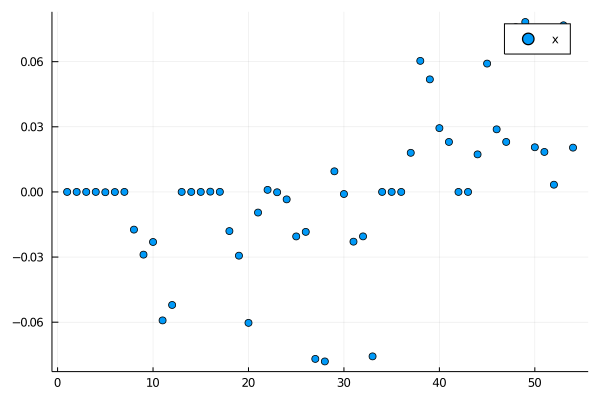

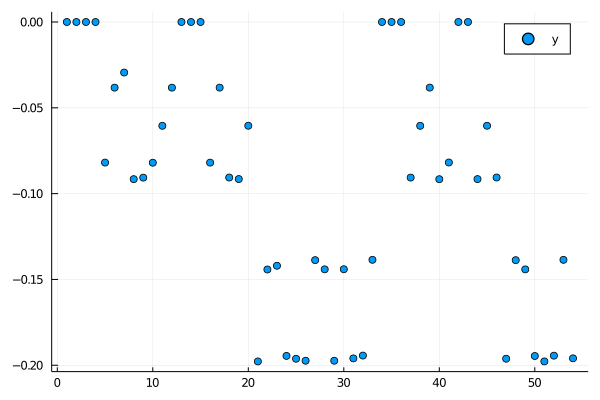

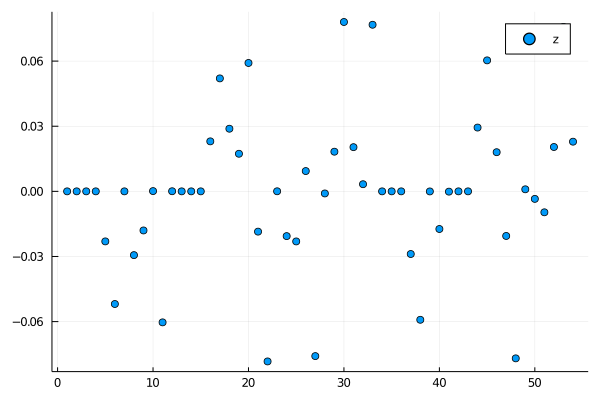

In [338]:
plotFinalDisplacement(name)

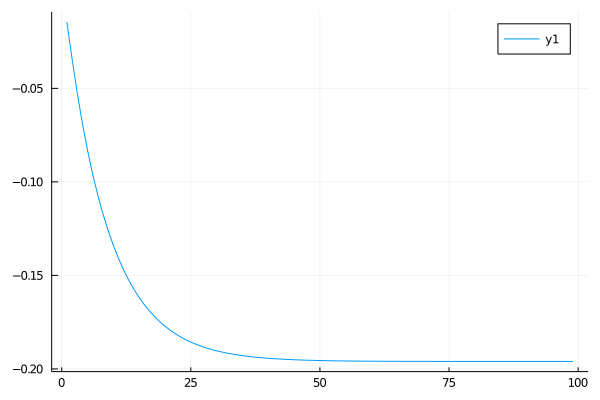

In [339]:
plotDisplacementTroughTimeSteps(name)